In [ ]:
# Uvoz potrebnih biblioteka, alata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

## Priprema podataka

In [ ]:
# Uvoz podataka - dataseta za trening i test modela - potrebni u root direktoriju
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

In [540]:
# Pregled podataka
# Ispis prvih nekoliko redova, informacija o DF-u i statističkih podataka
print(df_train.head())
print(df_train.info())
print(df_train.describe(include='all'))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [541]:
# Provjera da li postoje nedostajući podaci u trening i test datasetu
print(df_train.isnull().sum())
print("------------------")
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


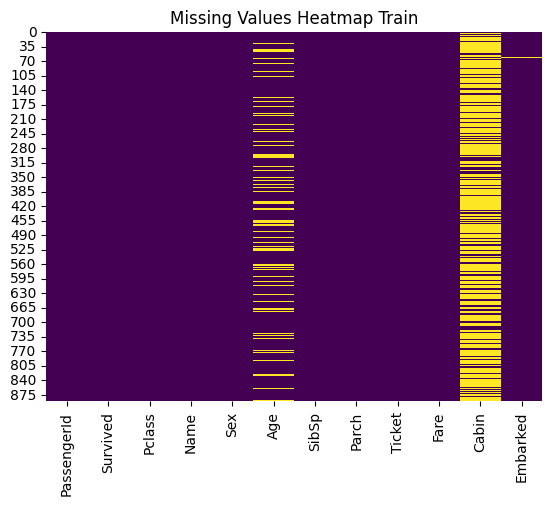

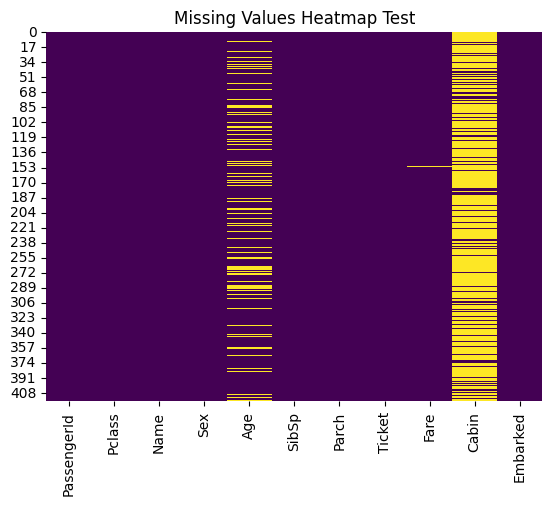

In [ ]:
# Vizualizacija nedostajućih podataka za trening i test dataset, na osnovu koje se odlučuje o daljnjim koracima
sns.heatmap(df_train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap Train")
plt.show()

sns.heatmap(df_test.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap Test")
plt.show()

In [ ]:
# Drop kolona koje su irelevantne za trening modela
# U ovom slučaju uklanjamo kolone koje ne doprinose modelu
# Cabin - previše nedostajućih podataka
# Name, Ticket, PassengerId - identifikatori koji ne doprinose modelu
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

df_train.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=cols_to_drop, inplace=True)

print(df_train.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


In [ ]:
# Popunjavanje nedostajućih vrijednosti u koloni 'Age' sa medijanom za oba dataset-a
# Medijan se koristi jer je manje osjetljiv na ekstremne vrijednosti
age_median = df_train['Age'].median()
df_train['Age'] = df_train['Age'].fillna(age_median)

# Isto se radi i za test dataset
df_test['Age'] = df_test['Age'].fillna(age_median)

print(df_train.isnull().sum())
print("------------------")
print(df_test.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64
------------------
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64


In [ ]:
# Popunjavanje nedostajuće vrijednosti u koloni "Fare" samo za test dataset, upotrebom medijana
# Mogućnost i ručne izmjene (jedna vrijednost), ali medijan je često bolji izbor
fare_median = df_train['Fare'].median()
df_test['Fare'] = df_test['Fare'].fillna(fare_median)

# Provjera da li su sada svi nedostajući podaci popunjeni
print(df_test.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [ ]:
# Popunjavanje nedostajućih vrijednosti u koloni 'Embarked' sa najčešćom vrijednošću (mod)
# 'Embarked' predstavlja luku ukrcaja, a najčešća luka će biti korištena za popunjavanje
embarked_mode = df_train['Embarked'].mode()[0]
df_train['Embarked'] = df_train['Embarked'].fillna(embarked_mode)

# Isto i za test skup, koristimo mod treninga
df_test['Embarked'] = df_test['Embarked'].fillna(embarked_mode)

print(df_train["Embarked"].head())
print("-------------------")
print(df_test["Embarked"].head())

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object
-------------------
0    Q
1    S
2    Q
3    S
4    S
Name: Embarked, dtype: object


In [ ]:
# Feature engineering
# Kreiranje nove kolone 'FamilySize' koja predstavlja veličinu porodice, uključujući putnika
# 'SibSp' (broj braće/sestara/partnera) i 'Parch' (broj roditelja/hranitelja)
# Ova kolona može pomoći u modeliranju preživljavanja, jer veće porodice mogu imati drugačije šanse za preživljavanje
# Izvršava se na oba dataset-a
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
print(df_train.head())
print("-------------------")
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
print(df_test.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize
0         0       3    male  22.0      1      0   7.2500        S           2
1         1       1  female  38.0      1      0  71.2833        C           2
2         1       3  female  26.0      0      0   7.9250        S           1
3         1       1  female  35.0      1      0  53.1000        S           2
4         0       3    male  35.0      0      0   8.0500        S           1
-------------------
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize
0       3    male  34.5      0      0   7.8292        Q           1
1       3  female  47.0      1      0   7.0000        S           2
2       2    male  62.0      0      0   9.6875        Q           1
3       3    male  27.0      0      0   8.6625        S           1
4       3  female  22.0      1      1  12.2875        S           3


In [ ]:
# Da li je putnik sam ili ne, ukoliko je FamilySize == 1, onda je putnik sam
# Kreira se nova kolona 'IsAlone' koja će imati vrijednost 1 ako je putnik sam, inače 0
# Ova kolona može pomoći u modeliranju preživljavanja, jer putnici koji su sami mogu imati drugačije šanse za preživljavanje
# Izvršava se na oba dataset-a
df_train['IsAlone'] = 0
df_train.loc[df_train['FamilySize'] == 1, 'IsAlone'] = 1

df_test['IsAlone'] = 0
df_test.loc[df_test['FamilySize'] == 1, 'IsAlone'] = 1

print(df_train[['FamilySize', 'IsAlone']].head())
print("-------------------")
print(df_test[['FamilySize', 'IsAlone']].head())

# Provjera da li IsAlone kolona ima smisla
# Ispis prosječne vrijednosti 'Survived' za putnike koji su sami i one koji nisu
# Ovo će pokazati da li su putnici koji su sami imali drugačije šanse za preživljavanje
# 0 znači da putnik nije preživio, 1 da jeste
print(df_train.groupby('IsAlone')['Survived'].mean())

   FamilySize  IsAlone
0           2        0
1           2        0
2           1        1
3           2        0
4           1        1
-------------------
   FamilySize  IsAlone
0           1        1
1           2        0
2           1        1
3           1        1
4           3        0
IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64


In [ ]:
# Mapiranje kategorijskih varijabli u numeričke, male - 0, female - 1
# Ova transformacija je potrebna za modele koji ne podržavaju kategorijske varijable
# Ovdje se koristi mapiranje za kolonu Gender/Sex
# Ispis prije i poslije mapiranja
print(df_train["Sex"].head())
print("-------------------")

sex_map = {'male': 0, 'female': 1}
df_train['Sex'] = df_train['Sex'].map(sex_map)
df_test['Sex'] = df_test['Sex'].map(sex_map)

print(df_train["Sex"].head())
print("-------------------")
print(df_test["Sex"].head())

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object
-------------------
0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64
-------------------
0    0
1    1
2    0
3    0
4    1
Name: Sex, dtype: int64


In [ ]:
# Ova transformacija je potrebna za modele koji ne podržavaju kategorijske varijable
# Ovdje se koristi one-hot encoding za kolonu 'Embarked'
df_train = pd.get_dummies(df_train, columns=['Embarked'])
df_test = pd.get_dummies(df_test, columns=['Embarked'])

print(df_train.head())
print("-------------------")
print(df_test.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  \
0         0       3    0  22.0      1      0   7.2500           2        0   
1         1       1    1  38.0      1      0  71.2833           2        0   
2         1       3    1  26.0      0      0   7.9250           1        1   
3         1       1    1  35.0      1      0  53.1000           2        0   
4         0       3    0  35.0      0      0   8.0500           1        1   

   Embarked_C  Embarked_Q  Embarked_S  
0       False       False        True  
1        True       False       False  
2       False       False        True  
3       False       False        True  
4       False       False        True  
-------------------
   Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  Embarked_C  \
0       3    0  34.5      0      0   7.8292           1        1       False   
1       3    1  47.0      1      0   7.0000           2        0       False   
2       2    0  62.0      0    

In [ ]:
# Pregled podataka i sortiranje kolona
df_test = df_test[df_train.columns.drop("Survived")]

print(df_train.head())
print("-------------------")
print(df_test.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  \
0         0       3    0  22.0      1      0   7.2500           2        0   
1         1       1    1  38.0      1      0  71.2833           2        0   
2         1       3    1  26.0      0      0   7.9250           1        1   
3         1       1    1  35.0      1      0  53.1000           2        0   
4         0       3    0  35.0      0      0   8.0500           1        1   

   Embarked_C  Embarked_Q  Embarked_S  
0       False       False        True  
1        True       False       False  
2       False       False        True  
3       False       False        True  
4       False       False        True  
-------------------
   Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  Embarked_C  \
0       3    0  34.5      0      0   7.8292           1        1       False   
1       3    1  47.0      1      0   7.0000           2        0       False   
2       2    0  62.0      0    

In [ ]:
# Podjela podataka na X (features) i y (target) za trening dataset - Features sve kolone osim 'Survived'
# 'Survived' je target varijabla koju želimo predvidjeti - preživio ili ne
X = df_train.drop(columns=['Survived'])
y = df_train['Survived']

# Podjela podataka na trening i validaciju
# koristi se train_test_split iz sklearn biblioteke
# podjela se vrši na 80% za trening i 20% za validaciju
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Podjela podataka na X (features) za test dataset - u ovom slučaju nije upotrebljen jer je sam fokus na kreiranju i evaluaciji modela
# Da bi se dobio submission.csv - za takmičenje Kaggle
X_test = df_test.copy()

## Treniranje modela

In [ ]:
# Random Forest Classifier - treniranje modela, hiperparametri
# Definisanje skupa hiperparametara za GridSearchCV
# NOTE: zbog velikog broja kombinacija, GridSearchCV u ovom slučaju može biti spor
param_grid = {
    'n_estimators': [100, 500, 1000], # Broj stabala u šumi
    'max_depth': [None, 10, 20, 30], # Maksimalna dubina stabla
    'min_samples_split': [2, 5], # Minimalan broj uzoraka potreban za podjelu čvora
    'min_samples_leaf': [1, 2, 4], # Minimalan broj uzoraka u listu
    'max_features': ['sqrt', 0.3], # Broj karakteristika koje se koriste za podjelu čvora
    'class_weight': [None, 'balanced'], # Težine klasa za nerazmjerno raspoređene klase
    'bootstrap': [True, False], # Da li koristiti bootstrap uzorkovanje
}

# Inicijalizacija GridSearchCV sa RandomForestClassifier
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                 param_grid=param_grid,
                                 cv=5, # K-fold cross-validation
                                 scoring='recall', # Metrika za evaluaciju
                                 n_jobs=-1, # Koristi sve dostupne CPU jezgre
                                 verbose=2)

# Treniranje Random Forest modela koristeći GridSearchCV
rf_grid.fit(X_train, y_train)

# Ispis najboljih hiperparametara i najbolje tačnosti
best_rf_model = rf_grid.best_estimator_
print("Best Hyperparameters:", rf_grid.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Hyperparameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [554]:
# Logistic Regression - treniranje modela, hiperparametri
# Definisanje skupa hiperparametara za GridSearchCV
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Inverzna regularizacija
    'penalty': ['l1', 'l2'], # Regularizacija
    'solver': ['liblinear'], # Solver za optimizaciju
    'class_weight': ['balanced'], # Težine klasa za nerazmjerno raspoređene klase
    'max_iter': [1000] # Maksimalan broj iteracija
}

# Inicijalizacija GridSearchCV sa LogisticRegression
lr_grid = GridSearchCV(estimator=LogisticRegression(), 
                                 param_grid=lr_param_grid, 
                                 cv=5, # K-fold cross-validation
                                 scoring='accuracy', # Metrika za evaluaciju
                                 n_jobs=-1, # Koristi sve dostupne CPU jezgre
                                 verbose=2)

# Treniranje Logistic Regression modela koristeći GridSearchCV
lr_grid.fit(X_train, y_train)

# Ispis najboljih hiperparametara i najbolje tačnosti
best_lr_model = lr_grid.best_estimator_
print("Best Hyperparameters for Logistic Regression:", lr_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for Logistic Regression: {'C': 100, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


In [555]:
# Predikcija sa Random Forest modelom
rf_predictions = best_rf_model.predict(X_val)

# Predikcija sa Logistic Regression modelom
best_lr_model = best_lr_model.predict(X_val)

## Evaluacija modela

In [556]:
# Funkcija za evaluaciju modela i vraćanje metrika
def print_metrics(y_true, y_pred, model_name):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

    labels = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color="cornflowerblue")
    plt.ylim(0, 1.05)
    plt.title(f"Evaluacione metrike za {model_name}")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    plt.ylabel("Vrijednost")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
# Funkcija za iscrtavanje classification report-a
def plot_classification_report(y_true, y_pred, model_name="Model"):
    # Dobijanje classification report-a kao dict
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Konverzija u DataFrame
    df = pd.DataFrame(report).transpose()

    # Plot heatmap (isključujemo "support" kolonu jer nije metrike)
    metrics = df.drop(columns=["support"], errors="ignore")

    plt.figure(figsize=(8, 5))
    sns.heatmap(metrics, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"Classification Report - {model_name}")
    plt.yticks(rotation=0)
    plt.show()

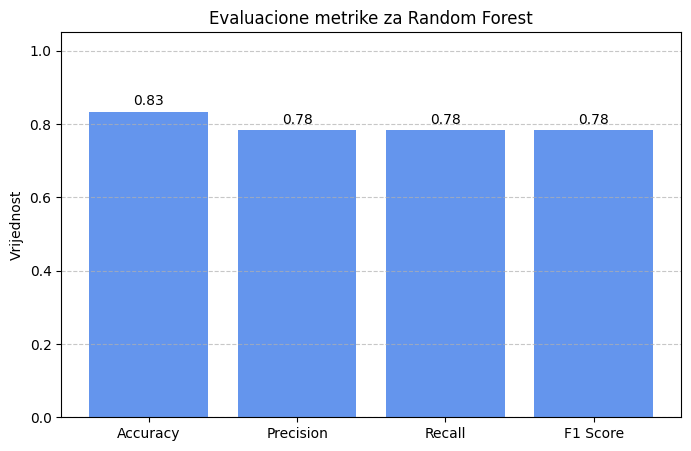

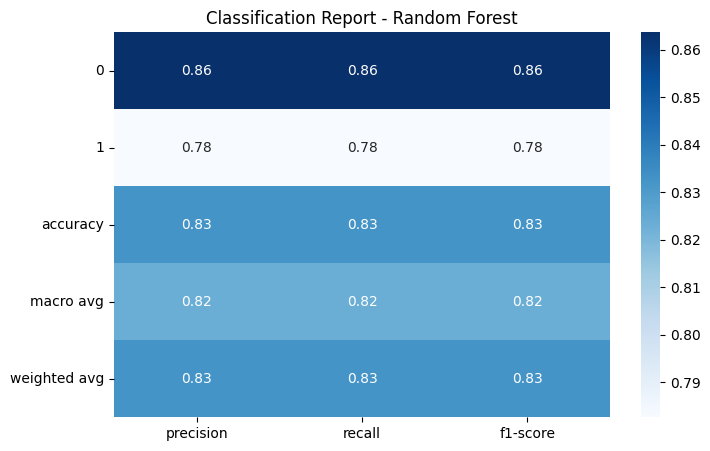

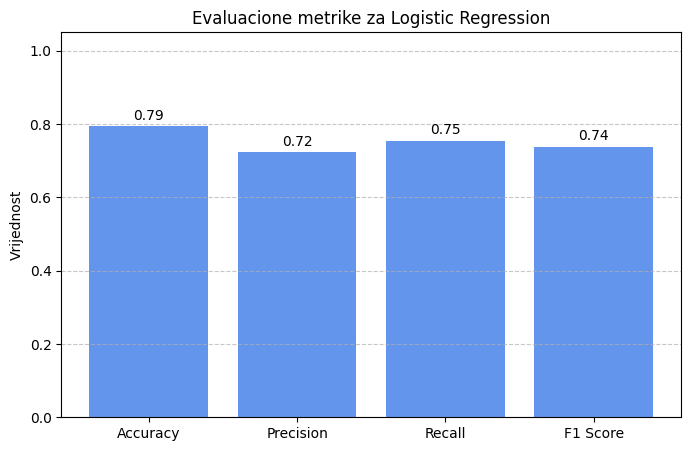

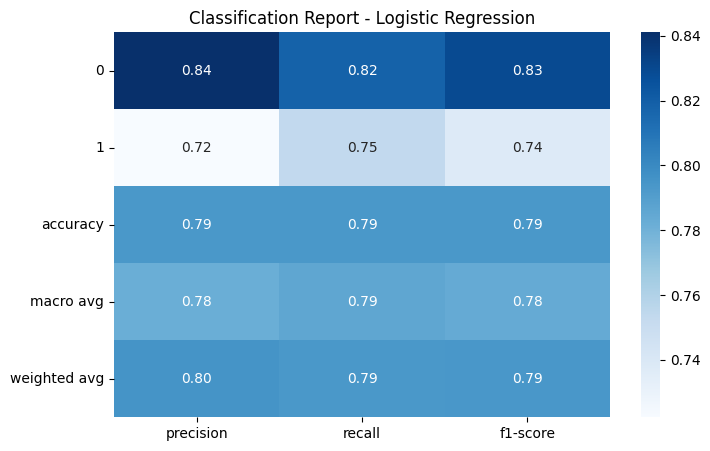

In [564]:
# Evaluacija modela sa osnovnim metrikama
print_metrics(y_val, rf_predictions, "Random Forest")
plot_classification_report(y_val, rf_predictions, "Random Forest")
# Evaluacija Logistic Regression modela
print_metrics(y_val, best_lr_model, "Logistic Regression")
plot_classification_report(y_val, best_lr_model, "Logistic Regression")

In [559]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

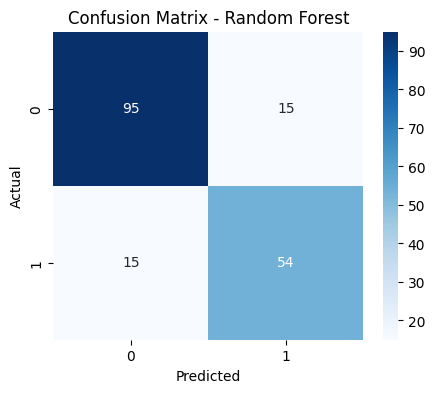

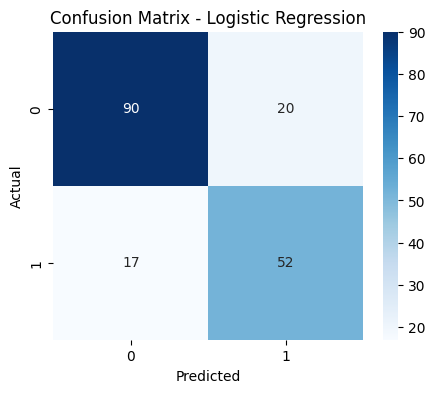

In [560]:
# Ispis Confusion Matrix za modele
plot_confusion_matrix(y_val, rf_predictions, "Random Forest")
plot_confusion_matrix(y_val, best_lr_model, "Logistic Regression")

In [ ]:
# NOTE: Dodatno RF za Kaggle submission
rf_final_predictions = best_rf_model.predict(X_test)
# Kreiranje DataFrame za submission
submission_df = pd.DataFrame({
    'PassengerId': df_test.index + 892,  # Indexiranje počinje od 892 za test dataset
    'Survived': rf_final_predictions
})
# Spremanje u CSV datoteku
submission_df.to_csv('submission.csv', index=False)